## New York City Taxi Trip Duration

**This is the workshop project collaborated by Xinyuan Xu**$^*$**, Xindi Shen**$^*$**, Zhitong Xu**$^*$**, Hanyuan Zhang**$^*$**, Linling Huang**$^*$ ***($*$=equal contribution)***

**Last updated: Jan 15th, 2022**
## Problem Description

In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## Data Description

The competition dataset is based on the [2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data/nyc-tlc-trips) made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

### Full Description

### Description
Colonne | Description
------- | -------
**id** | a unique identifier for each trip  
**vendor_id** | a code indicating the provider associated with the trip record  
**pickup_datetime** | date and time when the meter was engaged  
**dropoff_datetime** | date and time when the meter was disengaged  
**passenger_count** | the number of passengers in the vehicle (driver entered value)  
**pickup_longitude** | the longitude where the meter was engaged  
**pickup_latitude** | the latitude where the meter was engaged  
**dropoff_longitude** | the longitude where the meter was disengaged  
**dropoff_latitude** | the latitude where the meter was disengaged  
**store_and_fwd_flag** | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)  
**trip_duration** | duration of the trip in seconds  


In [233]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [234]:
df = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")

In [235]:
#Remove trips without passengers
df = df[df['passenger_count'] > 0]

In [236]:
#Remove position outliers
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85) 
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

In [237]:
#Remove duration outliers
duration_border = (60, 10800)
df = df[df['trip_duration'] >= 60]
df = df[df['trip_duration'] <= 10800]

In [238]:
df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)

df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df_test['pickup_datetime'] = pd.to_datetime(df_test.pickup_datetime)
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.date
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)

# Extracting Month, day of Week and Hour
df['Month'] = df['pickup_datetime'].dt.month
df_test['Month'] = df_test['pickup_datetime'].dt.month

df['DayofMonth'] = df['pickup_datetime'].dt.day
df_test['DayofMonth'] = df_test['pickup_datetime'].dt.day

df['Hour'] = df['pickup_datetime'].dt.hour
df_test['Hour'] = df_test['pickup_datetime'].dt.hour

df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df_test['dayofweek'] = df_test['pickup_datetime'].dt.dayofweek

#保留第一列id，输出submission用
df_test_id = df_test.iloc[:, 0]

In [239]:
#One-hot encoding binary categorical features
df = pd.concat([df, pd.get_dummies(df['store_and_fwd_flag'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['store_and_fwd_flag'])], axis=1)

df.drop(['store_and_fwd_flag'], axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['vendor_id'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['vendor_id'])], axis=1)

df.drop(['vendor_id'], axis=1, inplace=True)

In [240]:
df_test.drop(['store_and_fwd_flag'], axis=1, inplace=True)
df_test.drop(['vendor_id'], axis=1, inplace=True)

In [241]:
# #天气数据
# weather_hour = pd.read_csv("../input/Weather.csv")
# weather = pd.read_csv("../input/weather_data_nyc_centralpark_2016.csv")
# # Weather dataframe
# weather.replace('T', 0.001, inplace=True)
# weather['pickup_date'] = pd.to_datetime(weather['date'], dayfirst=True).dt.date
# weather['average temperature'] = weather['average temperature'].astype(np.int64)
# weather['precipitation'] = weather['precipitation'].astype(np.float64)
# weather['snow fall'] = weather['snow fall'].astype(np.float64)
# weather['snow depth'] = weather['snow depth'].astype(np.float64)
# # Weather hourly dataframe
# weather_hour['Datetime'] = pd.to_datetime(weather_hour['pickup_datetime'], dayfirst=True)
# weather_hour['pickup_date'] = weather_hour.Datetime.dt.date
# weather_hour['hour'] = weather_hour['Datetime'].dt.hour
# weather_hour['fog'] = weather_hour.fog.astype(np.int8)
# weather_hour.drop(['pickup_datetime', 'Datetime'], inplace=True, axis=1)

# #weather_hour去重
# weather_hour = weather_hour.drop_duplicates(['pickup_date','hour'])

# #把两个天气的数据加进去
# df = pd.merge(df, weather, on = 'pickup_date')
# df = pd.merge(df, weather_hour, on = ['pickup_date', 'hour'])
# df_test = pd.merge(df_test, weather, on = 'pickup_date')
# df_test = pd.merge(df_test, weather_hour, on = ['pickup_date', 'hour'])

# #OSRM数据
# fr1 = pd.read_csv('../input/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
# fr2 = pd.read_csv('../input/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
# df_test_street_info = pd.read_csv('../input/fastest_routes_test.csv',
#                                usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
# df_street_info = pd.concat((fr1, fr2))
# df = df.merge(df_street_info, how='left', on='id')
# df_test = df_test.merge(df_test_street_info, how='left', on='id')

# #方向
# def bearing_array(lat1, lng1, lat2, lng2):
#     #AVG_EARTH_RADIUS = 6371  # in km
#     lng_delta_rad = np.radians(lng2 - lng1)
#     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
#     y = np.sin(lng_delta_rad) * np.cos(lat2)
#     x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
#     return np.degrees(np.arctan2(y, x))

# df.loc[:, 'direction'] = bearing_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
# df_test.loc[:, 'direction'] = bearing_array(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, df_test['dropoff_latitude'].values, df_test['dropoff_longitude'].values)

# df.drop(['pickup_date','date','wdire','conds','icon','hail','thunder','tornado'], inplace=True, axis=1)
# df_test.drop(['pickup_date','date','wdire','conds','icon','hail','thunder','tornado'], inplace=True, axis=1)

In [242]:
df.drop(['pickup_datetime', 'dropoff_datetime','pickup_date'], inplace=True, axis=1)
df_test.drop(['pickup_datetime','pickup_date'], inplace=True, axis=1)

In [243]:
# df = df.fillna(method='ffill') 
# df_test = df_test.fillna(method='ffill') 

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429060 entries, 0 to 1458643
Data columns (total 16 columns):
id                   1429060 non-null object
passenger_count      1429060 non-null int64
pickup_longitude     1429060 non-null float64
pickup_latitude      1429060 non-null float64
dropoff_longitude    1429060 non-null float64
dropoff_latitude     1429060 non-null float64
trip_duration        1429060 non-null int64
log_trip_duration    1429060 non-null float64
Month                1429060 non-null int64
DayofMonth           1429060 non-null int64
Hour                 1429060 non-null int64
dayofweek            1429060 non-null int64
N                    1429060 non-null uint8
Y                    1429060 non-null uint8
1                    1429060 non-null uint8
2                    1429060 non-null uint8
dtypes: float64(5), int64(6), object(1), uint8(4)
memory usage: 147.2+ MB


In [245]:
y = df["log_trip_duration"]
df.drop(["log_trip_duration","trip_duration"], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)
X = df
X.shape, y.shape

((1429060, 13), (1429060,))

In [246]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1143248, 13), (1143248,), (285812, 13), (285812,))

In [247]:
from sklearn.metrics import mean_squared_error as MSE

In [248]:
df.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Month,DayofMonth,Hour,dayofweek,N,Y,1,2
count,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06,1.429060e+06
mean,1.665488e+00,-7.397394e+01,4.075109e+01,-7.397369e+01,4.075171e+01,3.515642e+00,1.550210e+01,1.362077e+01,3.048073e+00,9.945734e-01,5.426644e-03,4.650295e-01,5.349705e-01
std,1.315170e+00,3.693400e-02,2.734156e-02,3.230952e-02,2.956187e-02,1.681102e+00,8.702437e+00,6.377289e+00,1.953349e+00,7.346563e-02,7.346563e-02,4.987757e-01,4.987757e-01
min,1.000000e+00,-7.402968e+01,4.063000e+01,-7.403000e+01,4.063000e+01,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,-7.399188e+01,4.073751e+01,-7.399130e+01,4.073631e+01,2.000000e+00,8.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,-7.398179e+01,4.075414e+01,-7.397988e+01,4.075454e+01,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.000000e+00,-7.396760e+01,4.076833e+01,-7.396357e+01,4.076954e+01,5.000000e+00,2.300000e+01,1.900000e+01,5.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,6.000000e+00,-7.375282e+01,4.085000e+01,-7.375000e+01,4.085000e+01,6.000000e+00,3.100000e+01,2.300000e+01,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


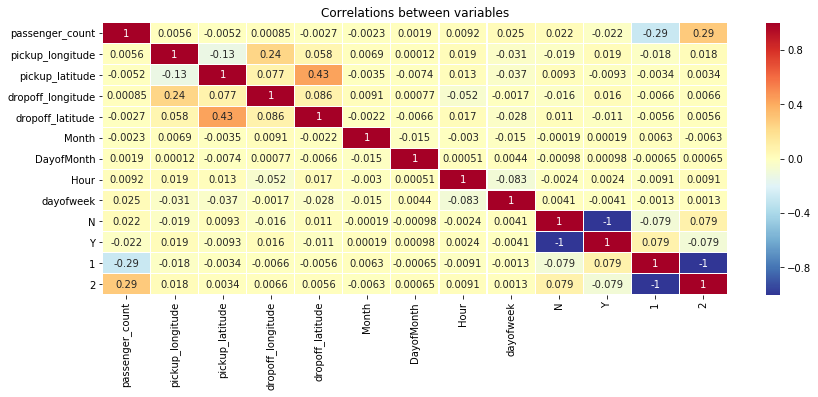

In [249]:
import seaborn as sns

#Correlations between variables
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=df.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [250]:
# Try GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train), gb.score(X_test, y_test))
print(np.sqrt(MSE(y_test, gb.predict(X_test))))

0.48580240744372377 0.48499187047016057
0.5180793172790291


In [257]:
import lightgbm as lgb
lgb_params = {
    'metric': 'rmse',
    'is_training_metric': True}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=5)


[1]	training's rmse: 0.692524	valid_1's rmse: 0.691508
Training until validation scores don't improve for 5 rounds.
[2]	training's rmse: 0.66922	valid_1's rmse: 0.668317
[3]	training's rmse: 0.64743	valid_1's rmse: 0.646666
[4]	training's rmse: 0.629837	valid_1's rmse: 0.629171
[5]	training's rmse: 0.613973	valid_1's rmse: 0.613399
[6]	training's rmse: 0.598076	valid_1's rmse: 0.59759
[7]	training's rmse: 0.585834	valid_1's rmse: 0.58542
[8]	training's rmse: 0.576329	valid_1's rmse: 0.575949
[9]	training's rmse: 0.565916	valid_1's rmse: 0.565601
[10]	training's rmse: 0.555509	valid_1's rmse: 0.555234
[11]	training's rmse: 0.548122	valid_1's rmse: 0.547874
[12]	training's rmse: 0.541271	valid_1's rmse: 0.541053
[13]	training's rmse: 0.534919	valid_1's rmse: 0.534728
[14]	training's rmse: 0.528845	valid_1's rmse: 0.528654
[15]	training's rmse: 0.524032	valid_1's rmse: 0.523889
[16]	training's rmse: 0.519875	valid_1's rmse: 0.519748
[17]	training's rmse: 0.515577	valid_1's rmse: 0.515402


In [262]:
#Hyperparameters tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}


In [263]:
lgb_params = {
    #'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=1500, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=5)


[1]	training's l2: 0.487579	valid_1's l2: 0.486573
Training until validation scores don't improve for 5 rounds.
[2]	training's l2: 0.441393	valid_1's l2: 0.4409
[3]	training's l2: 0.399686	valid_1's l2: 0.399529
[4]	training's l2: 0.363641	valid_1's l2: 0.363932
[5]	training's l2: 0.325528	valid_1's l2: 0.326119
[6]	training's l2: 0.29332	valid_1's l2: 0.294264
[7]	training's l2: 0.267604	valid_1's l2: 0.268789
[8]	training's l2: 0.250971	valid_1's l2: 0.252333
[9]	training's l2: 0.232129	valid_1's l2: 0.233691
[10]	training's l2: 0.224164	valid_1's l2: 0.225918
[11]	training's l2: 0.21414	valid_1's l2: 0.216076
[12]	training's l2: 0.201516	valid_1's l2: 0.20363
[13]	training's l2: 0.19397	valid_1's l2: 0.196234
[14]	training's l2: 0.189974	valid_1's l2: 0.192407
[15]	training's l2: 0.180284	valid_1's l2: 0.182916
[16]	training's l2: 0.171628	valid_1's l2: 0.17441
[17]	training's l2: 0.164895	valid_1's l2: 0.167807
[18]	training's l2: 0.15951	valid_1's l2: 0.16257
[19]	training's l2: 0

In [264]:
#Training on all labeled data using the best parameters
lgb_df = lgb.Dataset(X, y)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)


In [265]:
#Create a data frame designed a submission on Kaggle
# df_test.drop(['id'], axis=1, inplace=True)
predictions = lgb_model.predict(df_test)
submission = pd.DataFrame({'id': df_test_id, 'trip_duration': np.exp(predictions)-1})

In [266]:
#Create a csv out of the submission data frame
submission.to_csv("../output/sub-0118-3.csv", index=False)